In [1]:
#Importing libraries
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [8]:
# !pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Parameters

# Root directory for dataset
dataroot = "data/flow1"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
#Preparing the dataset and applying transformations to the images in the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [4]:
#Actually loading the data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [5]:
# Deciding which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) #mean, stddev as given in the paper
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
#Generator Code
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
#Creating the discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(512, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [30]:
# Training Loop
netG.load_state_dict(torch.load('sunflower/netG_epoch_499.pth', map_location=torch.device('cpu')))
netD.load_state_dict(torch.load('sunflower/netD_epoch_499.pth', map_location=torch.device('cpu')))
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    torch.save(netG.state_dict(), f'sunflower/netG_epoch_{epoch}.pth')
    torch.save(netD.state_dict(), f'sunflower/netD_epoch_{epoch}.pth')

Starting Training Loop...
[0/2000][0/1]	Loss_D: 0.0103	Loss_G: 6.3256	D(x): 0.9940	D(G(z)): 0.0043 / 0.0027
[1/2000][0/1]	Loss_D: 0.0148	Loss_G: 6.4727	D(x): 0.9959	D(G(z)): 0.0105 / 0.0023
[2/2000][0/1]	Loss_D: 0.0156	Loss_G: 6.7719	D(x): 0.9935	D(G(z)): 0.0090 / 0.0015
[3/2000][0/1]	Loss_D: 0.0125	Loss_G: 6.6372	D(x): 0.9894	D(G(z)): 0.0018 / 0.0018
[4/2000][0/1]	Loss_D: 0.0096	Loss_G: 6.0748	D(x): 0.9947	D(G(z)): 0.0043 / 0.0035
[5/2000][0/1]	Loss_D: 0.0149	Loss_G: 6.2498	D(x): 0.9965	D(G(z)): 0.0113 / 0.0024
[6/2000][0/1]	Loss_D: 0.0082	Loss_G: 7.0536	D(x): 0.9942	D(G(z)): 0.0023 / 0.0013
[7/2000][0/1]	Loss_D: 0.0126	Loss_G: 6.0543	D(x): 0.9947	D(G(z)): 0.0072 / 0.0029
[8/2000][0/1]	Loss_D: 0.0145	Loss_G: 6.2037	D(x): 0.9940	D(G(z)): 0.0084 / 0.0026
[9/2000][0/1]	Loss_D: 0.0109	Loss_G: 6.3224	D(x): 0.9918	D(G(z)): 0.0026 / 0.0022
[10/2000][0/1]	Loss_D: 0.0099	Loss_G: 6.2374	D(x): 0.9947	D(G(z)): 0.0045 / 0.0034
[11/2000][0/1]	Loss_D: 0.0112	Loss_G: 6.3070	D(x): 0.9959	D(G(z)): 0.00

[99/2000][0/1]	Loss_D: 0.0065	Loss_G: 6.5915	D(x): 0.9969	D(G(z)): 0.0034 / 0.0017
[100/2000][0/1]	Loss_D: 0.0051	Loss_G: 7.0220	D(x): 0.9962	D(G(z)): 0.0013 / 0.0012
[101/2000][0/1]	Loss_D: 0.0059	Loss_G: 6.3189	D(x): 0.9971	D(G(z)): 0.0030 / 0.0023
[102/2000][0/1]	Loss_D: 0.0064	Loss_G: 6.4481	D(x): 0.9975	D(G(z)): 0.0038 / 0.0020
[103/2000][0/1]	Loss_D: 0.0051	Loss_G: 6.7927	D(x): 0.9972	D(G(z)): 0.0023 / 0.0016
[104/2000][0/1]	Loss_D: 0.0063	Loss_G: 6.5540	D(x): 0.9971	D(G(z)): 0.0034 / 0.0020
[105/2000][0/1]	Loss_D: 0.0059	Loss_G: 6.6638	D(x): 0.9968	D(G(z)): 0.0026 / 0.0018
[106/2000][0/1]	Loss_D: 0.0065	Loss_G: 6.3662	D(x): 0.9968	D(G(z)): 0.0032 / 0.0022
[107/2000][0/1]	Loss_D: 0.0085	Loss_G: 6.5032	D(x): 0.9968	D(G(z)): 0.0053 / 0.0020
[108/2000][0/1]	Loss_D: 0.0066	Loss_G: 6.6716	D(x): 0.9955	D(G(z)): 0.0020 / 0.0017
[109/2000][0/1]	Loss_D: 0.0048	Loss_G: 6.7348	D(x): 0.9966	D(G(z)): 0.0014 / 0.0016
[110/2000][0/1]	Loss_D: 0.0084	Loss_G: 6.3690	D(x): 0.9977	D(G(z)): 0.0061 / 

[197/2000][0/1]	Loss_D: 0.0055	Loss_G: 7.3288	D(x): 0.9961	D(G(z)): 0.0015 / 0.0014
[198/2000][0/1]	Loss_D: 0.0056	Loss_G: 6.8050	D(x): 0.9970	D(G(z)): 0.0026 / 0.0021
[199/2000][0/1]	Loss_D: 0.0088	Loss_G: 6.9519	D(x): 0.9975	D(G(z)): 0.0062 / 0.0017
[200/2000][0/1]	Loss_D: 0.0069	Loss_G: 7.2005	D(x): 0.9950	D(G(z)): 0.0018 / 0.0015
[201/2000][0/1]	Loss_D: 0.0053	Loss_G: 6.9085	D(x): 0.9970	D(G(z)): 0.0022 / 0.0023
[202/2000][0/1]	Loss_D: 0.0062	Loss_G: 7.0401	D(x): 0.9977	D(G(z)): 0.0039 / 0.0016
[203/2000][0/1]	Loss_D: 0.0049	Loss_G: 7.2361	D(x): 0.9969	D(G(z)): 0.0017 / 0.0014
[204/2000][0/1]	Loss_D: 0.0047	Loss_G: 6.9521	D(x): 0.9973	D(G(z)): 0.0020 / 0.0018
[205/2000][0/1]	Loss_D: 0.0087	Loss_G: 6.8033	D(x): 0.9978	D(G(z)): 0.0065 / 0.0019
[206/2000][0/1]	Loss_D: 0.0054	Loss_G: 7.4960	D(x): 0.9960	D(G(z)): 0.0013 / 0.0011
[207/2000][0/1]	Loss_D: 0.0046	Loss_G: 7.2187	D(x): 0.9968	D(G(z)): 0.0014 / 0.0016
[208/2000][0/1]	Loss_D: 0.0053	Loss_G: 6.8100	D(x): 0.9978	D(G(z)): 0.0030 /

[295/2000][0/1]	Loss_D: 0.0042	Loss_G: 7.3035	D(x): 0.9977	D(G(z)): 0.0019 / 0.0013
[296/2000][0/1]	Loss_D: 0.0082	Loss_G: 7.2242	D(x): 0.9979	D(G(z)): 0.0061 / 0.0011
[297/2000][0/1]	Loss_D: 0.0058	Loss_G: 7.5695	D(x): 0.9963	D(G(z)): 0.0021 / 0.0010
[298/2000][0/1]	Loss_D: 0.0054	Loss_G: 7.1384	D(x): 0.9960	D(G(z)): 0.0014 / 0.0012
[299/2000][0/1]	Loss_D: 0.0041	Loss_G: 7.1540	D(x): 0.9973	D(G(z)): 0.0014 / 0.0014
[300/2000][0/1]	Loss_D: 0.0049	Loss_G: 6.8663	D(x): 0.9981	D(G(z)): 0.0030 / 0.0016
[301/2000][0/1]	Loss_D: 0.0097	Loss_G: 7.6363	D(x): 0.9980	D(G(z)): 0.0077 / 0.0007
[302/2000][0/1]	Loss_D: 0.0073	Loss_G: 7.4760	D(x): 0.9940	D(G(z)): 0.0012 / 0.0008
[303/2000][0/1]	Loss_D: 0.0054	Loss_G: 6.9357	D(x): 0.9960	D(G(z)): 0.0013 / 0.0015
[304/2000][0/1]	Loss_D: 0.0053	Loss_G: 6.8303	D(x): 0.9978	D(G(z)): 0.0031 / 0.0019
[305/2000][0/1]	Loss_D: 0.0055	Loss_G: 7.2192	D(x): 0.9980	D(G(z)): 0.0035 / 0.0012
[306/2000][0/1]	Loss_D: 0.0060	Loss_G: 7.4756	D(x): 0.9976	D(G(z)): 0.0035 /

[393/2000][0/1]	Loss_D: 1.1000	Loss_G: 15.4715	D(x): 0.7367	D(G(z)): 0.1009 / 0.0001
[394/2000][0/1]	Loss_D: 0.7311	Loss_G: 8.4799	D(x): 0.7754	D(G(z)): 0.0286 / 0.0224
[395/2000][0/1]	Loss_D: 1.2000	Loss_G: 17.8532	D(x): 0.9838	D(G(z)): 0.3469 / 0.0000
[396/2000][0/1]	Loss_D: 0.3827	Loss_G: 15.5339	D(x): 0.8343	D(G(z)): 0.0021 / 0.0013
[397/2000][0/1]	Loss_D: 0.1151	Loss_G: 8.7628	D(x): 0.9151	D(G(z)): 0.0119 / 0.0080
[398/2000][0/1]	Loss_D: 1.0407	Loss_G: 19.7570	D(x): 0.9836	D(G(z)): 0.5472 / 0.0000
[399/2000][0/1]	Loss_D: 1.7593	Loss_G: 13.6001	D(x): 0.3798	D(G(z)): 0.0001 / 0.0001
[400/2000][0/1]	Loss_D: 0.0236	Loss_G: 7.9646	D(x): 0.9835	D(G(z)): 0.0062 / 0.0075
[401/2000][0/1]	Loss_D: 0.2846	Loss_G: 9.1312	D(x): 0.9983	D(G(z)): 0.1648 / 0.0010
[402/2000][0/1]	Loss_D: 0.0506	Loss_G: 8.9573	D(x): 0.9940	D(G(z)): 0.0358 / 0.0019
[403/2000][0/1]	Loss_D: 0.0904	Loss_G: 8.6307	D(x): 0.9803	D(G(z)): 0.0582 / 0.0017
[404/2000][0/1]	Loss_D: 0.0635	Loss_G: 7.2227	D(x): 0.9731	D(G(z)): 0.0

[491/2000][0/1]	Loss_D: 0.0467	Loss_G: 7.2638	D(x): 0.9846	D(G(z)): 0.0296 / 0.0010
[492/2000][0/1]	Loss_D: 0.0310	Loss_G: 7.1025	D(x): 0.9779	D(G(z)): 0.0084 / 0.0015
[493/2000][0/1]	Loss_D: 0.0577	Loss_G: 7.4543	D(x): 0.9844	D(G(z)): 0.0398 / 0.0008
[494/2000][0/1]	Loss_D: 0.0495	Loss_G: 6.9103	D(x): 0.9682	D(G(z)): 0.0161 / 0.0017
[495/2000][0/1]	Loss_D: 0.0470	Loss_G: 7.1551	D(x): 0.9787	D(G(z)): 0.0245 / 0.0015
[496/2000][0/1]	Loss_D: 0.0431	Loss_G: 7.4555	D(x): 0.9806	D(G(z)): 0.0229 / 0.0011
[497/2000][0/1]	Loss_D: 0.0300	Loss_G: 7.1853	D(x): 0.9789	D(G(z)): 0.0084 / 0.0014
[498/2000][0/1]	Loss_D: 0.0563	Loss_G: 7.9103	D(x): 0.9870	D(G(z)): 0.0415 / 0.0010
[499/2000][0/1]	Loss_D: 0.0479	Loss_G: 7.8840	D(x): 0.9691	D(G(z)): 0.0145 / 0.0009
[500/2000][0/1]	Loss_D: 0.0288	Loss_G: 7.0022	D(x): 0.9809	D(G(z)): 0.0092 / 0.0016
[501/2000][0/1]	Loss_D: 0.0308	Loss_G: 6.3685	D(x): 0.9875	D(G(z)): 0.0178 / 0.0024
[502/2000][0/1]	Loss_D: 0.0379	Loss_G: 7.1504	D(x): 0.9874	D(G(z)): 0.0245 /

[589/2000][0/1]	Loss_D: 0.0134	Loss_G: 6.2762	D(x): 0.9936	D(G(z)): 0.0069 / 0.0028
[590/2000][0/1]	Loss_D: 0.0110	Loss_G: 6.4615	D(x): 0.9944	D(G(z)): 0.0054 / 0.0025
[591/2000][0/1]	Loss_D: 0.0149	Loss_G: 6.6131	D(x): 0.9947	D(G(z)): 0.0095 / 0.0020
[592/2000][0/1]	Loss_D: 0.0111	Loss_G: 6.9563	D(x): 0.9926	D(G(z)): 0.0036 / 0.0018
[593/2000][0/1]	Loss_D: 0.0075	Loss_G: 7.5092	D(x): 0.9933	D(G(z)): 0.0008 / 0.0009
[594/2000][0/1]	Loss_D: 0.0116	Loss_G: 6.4409	D(x): 0.9959	D(G(z)): 0.0075 / 0.0024
[595/2000][0/1]	Loss_D: 0.0084	Loss_G: 6.8449	D(x): 0.9958	D(G(z)): 0.0041 / 0.0021
[596/2000][0/1]	Loss_D: 0.0118	Loss_G: 6.6525	D(x): 0.9956	D(G(z)): 0.0073 / 0.0020
[597/2000][0/1]	Loss_D: 0.0146	Loss_G: 6.8829	D(x): 0.9943	D(G(z)): 0.0088 / 0.0017
[598/2000][0/1]	Loss_D: 0.0137	Loss_G: 6.3851	D(x): 0.9917	D(G(z)): 0.0053 / 0.0021
[599/2000][0/1]	Loss_D: 0.0104	Loss_G: 6.7163	D(x): 0.9924	D(G(z)): 0.0027 / 0.0023
[600/2000][0/1]	Loss_D: 0.0125	Loss_G: 6.2190	D(x): 0.9950	D(G(z)): 0.0075 /

[687/2000][0/1]	Loss_D: 0.0059	Loss_G: 7.4714	D(x): 0.9958	D(G(z)): 0.0017 / 0.0009
[688/2000][0/1]	Loss_D: 0.0055	Loss_G: 7.2203	D(x): 0.9962	D(G(z)): 0.0016 / 0.0013
[689/2000][0/1]	Loss_D: 0.0053	Loss_G: 7.0650	D(x): 0.9970	D(G(z)): 0.0022 / 0.0015
[690/2000][0/1]	Loss_D: 0.0107	Loss_G: 6.9836	D(x): 0.9974	D(G(z)): 0.0081 / 0.0016
[691/2000][0/1]	Loss_D: 0.0082	Loss_G: 7.1991	D(x): 0.9959	D(G(z)): 0.0041 / 0.0013
[692/2000][0/1]	Loss_D: 0.0072	Loss_G: 7.5846	D(x): 0.9948	D(G(z)): 0.0020 / 0.0012
[693/2000][0/1]	Loss_D: 0.0076	Loss_G: 6.7388	D(x): 0.9958	D(G(z)): 0.0033 / 0.0021
[694/2000][0/1]	Loss_D: 0.0052	Loss_G: 7.3459	D(x): 0.9965	D(G(z)): 0.0017 / 0.0012
[695/2000][0/1]	Loss_D: 0.0123	Loss_G: 7.2905	D(x): 0.9973	D(G(z)): 0.0095 / 0.0011
[696/2000][0/1]	Loss_D: 0.0082	Loss_G: 7.3779	D(x): 0.9949	D(G(z)): 0.0031 / 0.0013
[697/2000][0/1]	Loss_D: 0.0108	Loss_G: 6.8682	D(x): 0.9945	D(G(z)): 0.0052 / 0.0018
[698/2000][0/1]	Loss_D: 0.0081	Loss_G: 6.8851	D(x): 0.9949	D(G(z)): 0.0029 /

[785/2000][0/1]	Loss_D: 0.0294	Loss_G: 6.0178	D(x): 0.9849	D(G(z)): 0.0139 / 0.0031
[786/2000][0/1]	Loss_D: 0.0298	Loss_G: 6.0926	D(x): 0.9877	D(G(z)): 0.0171 / 0.0029
[787/2000][0/1]	Loss_D: 0.0337	Loss_G: 6.0494	D(x): 0.9873	D(G(z)): 0.0205 / 0.0032
[788/2000][0/1]	Loss_D: 0.0517	Loss_G: 6.6848	D(x): 0.9847	D(G(z)): 0.0326 / 0.0019
[789/2000][0/1]	Loss_D: 0.0380	Loss_G: 6.3659	D(x): 0.9729	D(G(z)): 0.0100 / 0.0023
[790/2000][0/1]	Loss_D: 0.0380	Loss_G: 6.0070	D(x): 0.9821	D(G(z)): 0.0193 / 0.0029
[791/2000][0/1]	Loss_D: 0.0328	Loss_G: 6.2249	D(x): 0.9861	D(G(z)): 0.0184 / 0.0028
[792/2000][0/1]	Loss_D: 0.0297	Loss_G: 6.1139	D(x): 0.9861	D(G(z)): 0.0154 / 0.0034
[793/2000][0/1]	Loss_D: 0.0289	Loss_G: 6.0319	D(x): 0.9864	D(G(z)): 0.0148 / 0.0035
[794/2000][0/1]	Loss_D: 0.0321	Loss_G: 6.0880	D(x): 0.9876	D(G(z)): 0.0193 / 0.0027
[795/2000][0/1]	Loss_D: 0.0364	Loss_G: 6.2517	D(x): 0.9851	D(G(z)): 0.0210 / 0.0025
[796/2000][0/1]	Loss_D: 0.0310	Loss_G: 6.2480	D(x): 0.9803	D(G(z)): 0.0107 /

[883/2000][0/1]	Loss_D: 0.0192	Loss_G: 5.7957	D(x): 0.9905	D(G(z)): 0.0095 / 0.0044
[884/2000][0/1]	Loss_D: 0.0146	Loss_G: 5.9262	D(x): 0.9914	D(G(z)): 0.0059 / 0.0040
[885/2000][0/1]	Loss_D: 0.0190	Loss_G: 5.7768	D(x): 0.9931	D(G(z)): 0.0119 / 0.0039
[886/2000][0/1]	Loss_D: 0.0214	Loss_G: 6.0773	D(x): 0.9912	D(G(z)): 0.0123 / 0.0034
[887/2000][0/1]	Loss_D: 0.0161	Loss_G: 6.3674	D(x): 0.9872	D(G(z)): 0.0030 / 0.0028
[888/2000][0/1]	Loss_D: 0.0149	Loss_G: 5.7891	D(x): 0.9926	D(G(z)): 0.0074 / 0.0045
[889/2000][0/1]	Loss_D: 0.0152	Loss_G: 5.7937	D(x): 0.9940	D(G(z)): 0.0091 / 0.0045
[890/2000][0/1]	Loss_D: 0.0145	Loss_G: 6.0942	D(x): 0.9935	D(G(z)): 0.0080 / 0.0034
[891/2000][0/1]	Loss_D: 0.0150	Loss_G: 5.9916	D(x): 0.9924	D(G(z)): 0.0072 / 0.0036
[892/2000][0/1]	Loss_D: 0.0150	Loss_G: 6.0001	D(x): 0.9920	D(G(z)): 0.0070 / 0.0038
[893/2000][0/1]	Loss_D: 0.0117	Loss_G: 6.0226	D(x): 0.9923	D(G(z)): 0.0039 / 0.0031
[894/2000][0/1]	Loss_D: 0.0218	Loss_G: 6.1869	D(x): 0.9941	D(G(z)): 0.0156 /

[981/2000][0/1]	Loss_D: 0.0071	Loss_G: 6.7626	D(x): 0.9958	D(G(z)): 0.0028 / 0.0020
[982/2000][0/1]	Loss_D: 0.0110	Loss_G: 6.3180	D(x): 0.9960	D(G(z)): 0.0070 / 0.0030
[983/2000][0/1]	Loss_D: 0.0074	Loss_G: 6.9221	D(x): 0.9948	D(G(z)): 0.0022 / 0.0015
[984/2000][0/1]	Loss_D: 0.0077	Loss_G: 6.5852	D(x): 0.9956	D(G(z)): 0.0033 / 0.0027
[985/2000][0/1]	Loss_D: 0.0097	Loss_G: 6.4460	D(x): 0.9963	D(G(z)): 0.0059 / 0.0030
[986/2000][0/1]	Loss_D: 0.0151	Loss_G: 6.5999	D(x): 0.9955	D(G(z)): 0.0104 / 0.0021
[987/2000][0/1]	Loss_D: 0.0113	Loss_G: 7.5196	D(x): 0.9900	D(G(z)): 0.0011 / 0.0012
[988/2000][0/1]	Loss_D: 0.0083	Loss_G: 6.4388	D(x): 0.9947	D(G(z)): 0.0029 / 0.0035
[989/2000][0/1]	Loss_D: 0.0108	Loss_G: 6.3809	D(x): 0.9968	D(G(z)): 0.0075 / 0.0030
[990/2000][0/1]	Loss_D: 0.0096	Loss_G: 6.5620	D(x): 0.9958	D(G(z)): 0.0054 / 0.0024
[991/2000][0/1]	Loss_D: 0.0087	Loss_G: 6.6798	D(x): 0.9943	D(G(z)): 0.0030 / 0.0022
[992/2000][0/1]	Loss_D: 0.0109	Loss_G: 6.2194	D(x): 0.9951	D(G(z)): 0.0059 /

[1078/2000][0/1]	Loss_D: 0.0115	Loss_G: 6.5888	D(x): 0.9962	D(G(z)): 0.0076 / 0.0027
[1079/2000][0/1]	Loss_D: 0.0099	Loss_G: 6.7336	D(x): 0.9944	D(G(z)): 0.0043 / 0.0025
[1080/2000][0/1]	Loss_D: 0.0077	Loss_G: 7.1347	D(x): 0.9936	D(G(z)): 0.0012 / 0.0016
[1081/2000][0/1]	Loss_D: 0.0093	Loss_G: 6.2100	D(x): 0.9964	D(G(z)): 0.0056 / 0.0040
[1082/2000][0/1]	Loss_D: 0.0072	Loss_G: 6.6661	D(x): 0.9965	D(G(z)): 0.0037 / 0.0023
[1083/2000][0/1]	Loss_D: 0.0087	Loss_G: 6.6274	D(x): 0.9965	D(G(z)): 0.0052 / 0.0024
[1084/2000][0/1]	Loss_D: 0.0095	Loss_G: 6.3181	D(x): 0.9956	D(G(z)): 0.0051 / 0.0026
[1085/2000][0/1]	Loss_D: 0.0075	Loss_G: 7.1748	D(x): 0.9945	D(G(z)): 0.0020 / 0.0019
[1086/2000][0/1]	Loss_D: 0.0079	Loss_G: 6.1106	D(x): 0.9959	D(G(z)): 0.0038 / 0.0032
[1087/2000][0/1]	Loss_D: 0.0109	Loss_G: 6.3271	D(x): 0.9965	D(G(z)): 0.0074 / 0.0030
[1088/2000][0/1]	Loss_D: 0.0078	Loss_G: 6.4741	D(x): 0.9951	D(G(z)): 0.0029 / 0.0020
[1089/2000][0/1]	Loss_D: 0.0071	Loss_G: 6.5238	D(x): 0.9953	D(G(z

[1175/2000][0/1]	Loss_D: 0.0072	Loss_G: 6.3997	D(x): 0.9968	D(G(z)): 0.0039 / 0.0035
[1176/2000][0/1]	Loss_D: 0.0045	Loss_G: 7.0137	D(x): 0.9975	D(G(z)): 0.0021 / 0.0019
[1177/2000][0/1]	Loss_D: 0.0064	Loss_G: 6.5592	D(x): 0.9979	D(G(z)): 0.0042 / 0.0024
[1178/2000][0/1]	Loss_D: 0.0068	Loss_G: 7.0744	D(x): 0.9975	D(G(z)): 0.0042 / 0.0021
[1179/2000][0/1]	Loss_D: 0.0059	Loss_G: 6.8746	D(x): 0.9965	D(G(z)): 0.0023 / 0.0017
[1180/2000][0/1]	Loss_D: 0.0085	Loss_G: 6.5442	D(x): 0.9965	D(G(z)): 0.0049 / 0.0024
[1181/2000][0/1]	Loss_D: 0.0075	Loss_G: 6.4385	D(x): 0.9955	D(G(z)): 0.0029 / 0.0023
[1182/2000][0/1]	Loss_D: 0.0073	Loss_G: 6.5639	D(x): 0.9958	D(G(z)): 0.0030 / 0.0027
[1183/2000][0/1]	Loss_D: 0.0127	Loss_G: 6.7870	D(x): 0.9966	D(G(z)): 0.0091 / 0.0028
[1184/2000][0/1]	Loss_D: 0.0099	Loss_G: 6.6764	D(x): 0.9942	D(G(z)): 0.0040 / 0.0024
[1185/2000][0/1]	Loss_D: 0.0083	Loss_G: 6.6516	D(x): 0.9937	D(G(z)): 0.0018 / 0.0025
[1186/2000][0/1]	Loss_D: 0.0109	Loss_G: 6.2668	D(x): 0.9963	D(G(z

[1272/2000][0/1]	Loss_D: 0.0065	Loss_G: 6.5013	D(x): 0.9974	D(G(z)): 0.0039 / 0.0020
[1273/2000][0/1]	Loss_D: 0.0040	Loss_G: 7.6139	D(x): 0.9971	D(G(z)): 0.0010 / 0.0008
[1274/2000][0/1]	Loss_D: 0.0052	Loss_G: 6.5491	D(x): 0.9976	D(G(z)): 0.0027 / 0.0020
[1275/2000][0/1]	Loss_D: 0.0065	Loss_G: 6.3891	D(x): 0.9977	D(G(z)): 0.0042 / 0.0021
[1276/2000][0/1]	Loss_D: 0.0057	Loss_G: 6.7480	D(x): 0.9973	D(G(z)): 0.0030 / 0.0016
[1277/2000][0/1]	Loss_D: 0.0047	Loss_G: 6.9803	D(x): 0.9969	D(G(z)): 0.0016 / 0.0013
[1278/2000][0/1]	Loss_D: 0.0047	Loss_G: 6.7321	D(x): 0.9973	D(G(z)): 0.0020 / 0.0017
[1279/2000][0/1]	Loss_D: 0.0040	Loss_G: 6.8872	D(x): 0.9977	D(G(z)): 0.0017 / 0.0014
[1280/2000][0/1]	Loss_D: 0.0044	Loss_G: 6.7620	D(x): 0.9980	D(G(z)): 0.0024 / 0.0017
[1281/2000][0/1]	Loss_D: 0.0037	Loss_G: 6.8802	D(x): 0.9981	D(G(z)): 0.0017 / 0.0013
[1282/2000][0/1]	Loss_D: 0.0045	Loss_G: 6.6581	D(x): 0.9981	D(G(z)): 0.0026 / 0.0017
[1283/2000][0/1]	Loss_D: 0.0069	Loss_G: 6.5228	D(x): 0.9980	D(G(z

[1369/2000][0/1]	Loss_D: 0.0410	Loss_G: 7.1133	D(x): 0.9846	D(G(z)): 0.0247 / 0.0012
[1370/2000][0/1]	Loss_D: 0.0365	Loss_G: 6.6711	D(x): 0.9807	D(G(z)): 0.0165 / 0.0018
[1371/2000][0/1]	Loss_D: 0.0314	Loss_G: 6.5657	D(x): 0.9830	D(G(z)): 0.0139 / 0.0021
[1372/2000][0/1]	Loss_D: 0.0400	Loss_G: 7.0690	D(x): 0.9875	D(G(z)): 0.0268 / 0.0015
[1373/2000][0/1]	Loss_D: 0.0287	Loss_G: 6.9018	D(x): 0.9855	D(G(z)): 0.0138 / 0.0018
[1374/2000][0/1]	Loss_D: 0.0354	Loss_G: 6.5031	D(x): 0.9860	D(G(z)): 0.0209 / 0.0020
[1375/2000][0/1]	Loss_D: 0.0351	Loss_G: 6.7880	D(x): 0.9844	D(G(z)): 0.0189 / 0.0016
[1376/2000][0/1]	Loss_D: 0.0341	Loss_G: 6.4155	D(x): 0.9846	D(G(z)): 0.0182 / 0.0026
[1377/2000][0/1]	Loss_D: 0.0393	Loss_G: 6.4870	D(x): 0.9842	D(G(z)): 0.0229 / 0.0025
[1378/2000][0/1]	Loss_D: 0.0329	Loss_G: 6.3495	D(x): 0.9830	D(G(z)): 0.0153 / 0.0031
[1379/2000][0/1]	Loss_D: 0.0489	Loss_G: 6.9707	D(x): 0.9858	D(G(z)): 0.0331 / 0.0014
[1380/2000][0/1]	Loss_D: 0.0396	Loss_G: 6.5080	D(x): 0.9732	D(G(z

[1466/2000][0/1]	Loss_D: 0.0114	Loss_G: 6.5297	D(x): 0.9925	D(G(z)): 0.0038 / 0.0022
[1467/2000][0/1]	Loss_D: 0.0152	Loss_G: 6.6484	D(x): 0.9948	D(G(z)): 0.0099 / 0.0017
[1468/2000][0/1]	Loss_D: 0.0136	Loss_G: 6.6573	D(x): 0.9941	D(G(z)): 0.0077 / 0.0020
[1469/2000][0/1]	Loss_D: 0.0164	Loss_G: 6.5802	D(x): 0.9930	D(G(z)): 0.0093 / 0.0019
[1470/2000][0/1]	Loss_D: 0.0159	Loss_G: 6.7542	D(x): 0.9915	D(G(z)): 0.0073 / 0.0020
[1471/2000][0/1]	Loss_D: 0.0161	Loss_G: 6.4702	D(x): 0.9916	D(G(z)): 0.0076 / 0.0023
[1472/2000][0/1]	Loss_D: 0.0126	Loss_G: 6.6264	D(x): 0.9922	D(G(z)): 0.0047 / 0.0022
[1473/2000][0/1]	Loss_D: 0.0155	Loss_G: 6.8738	D(x): 0.9941	D(G(z)): 0.0095 / 0.0022
[1474/2000][0/1]	Loss_D: 0.0115	Loss_G: 6.7066	D(x): 0.9932	D(G(z)): 0.0046 / 0.0021
[1475/2000][0/1]	Loss_D: 0.0083	Loss_G: 6.9216	D(x): 0.9938	D(G(z)): 0.0020 / 0.0015
[1476/2000][0/1]	Loss_D: 0.0120	Loss_G: 6.5878	D(x): 0.9957	D(G(z)): 0.0076 / 0.0024
[1477/2000][0/1]	Loss_D: 0.0091	Loss_G: 6.8494	D(x): 0.9952	D(G(z

[1563/2000][0/1]	Loss_D: 0.0191	Loss_G: 6.6642	D(x): 0.9861	D(G(z)): 0.0018 / 0.0028
[1564/2000][0/1]	Loss_D: 0.0140	Loss_G: 6.0671	D(x): 0.9962	D(G(z)): 0.0101 / 0.0053
[1565/2000][0/1]	Loss_D: 0.0134	Loss_G: 6.5380	D(x): 0.9934	D(G(z)): 0.0065 / 0.0028
[1566/2000][0/1]	Loss_D: 0.0139	Loss_G: 6.6607	D(x): 0.9934	D(G(z)): 0.0071 / 0.0031
[1567/2000][0/1]	Loss_D: 0.0142	Loss_G: 6.3573	D(x): 0.9916	D(G(z)): 0.0055 / 0.0037
[1568/2000][0/1]	Loss_D: 0.0118	Loss_G: 6.1870	D(x): 0.9926	D(G(z)): 0.0043 / 0.0047
[1569/2000][0/1]	Loss_D: 0.0137	Loss_G: 6.3741	D(x): 0.9952	D(G(z)): 0.0087 / 0.0033
[1570/2000][0/1]	Loss_D: 0.0122	Loss_G: 6.4475	D(x): 0.9922	D(G(z)): 0.0042 / 0.0037
[1571/2000][0/1]	Loss_D: 0.0129	Loss_G: 6.2931	D(x): 0.9949	D(G(z)): 0.0077 / 0.0032
[1572/2000][0/1]	Loss_D: 0.0127	Loss_G: 6.4991	D(x): 0.9929	D(G(z)): 0.0054 / 0.0039
[1573/2000][0/1]	Loss_D: 0.0101	Loss_G: 6.3876	D(x): 0.9939	D(G(z)): 0.0039 / 0.0037
[1574/2000][0/1]	Loss_D: 0.0091	Loss_G: 6.6965	D(x): 0.9955	D(G(z

[1660/2000][0/1]	Loss_D: 0.0060	Loss_G: 6.7269	D(x): 0.9970	D(G(z)): 0.0030 / 0.0025
[1661/2000][0/1]	Loss_D: 0.0057	Loss_G: 6.9702	D(x): 0.9972	D(G(z)): 0.0029 / 0.0022
[1662/2000][0/1]	Loss_D: 0.0061	Loss_G: 6.7016	D(x): 0.9972	D(G(z)): 0.0032 / 0.0022
[1663/2000][0/1]	Loss_D: 0.0084	Loss_G: 6.4087	D(x): 0.9970	D(G(z)): 0.0053 / 0.0024
[1664/2000][0/1]	Loss_D: 0.0085	Loss_G: 6.6373	D(x): 0.9954	D(G(z)): 0.0038 / 0.0024
[1665/2000][0/1]	Loss_D: 0.0056	Loss_G: 7.8016	D(x): 0.9949	D(G(z)): 0.0004 / 0.0007
[1666/2000][0/1]	Loss_D: 0.0094	Loss_G: 6.6230	D(x): 0.9973	D(G(z)): 0.0066 / 0.0027
[1667/2000][0/1]	Loss_D: 0.0105	Loss_G: 6.9301	D(x): 0.9962	D(G(z)): 0.0065 / 0.0017
[1668/2000][0/1]	Loss_D: 0.0078	Loss_G: 7.1413	D(x): 0.9936	D(G(z)): 0.0012 / 0.0015
[1669/2000][0/1]	Loss_D: 0.0072	Loss_G: 6.2876	D(x): 0.9960	D(G(z)): 0.0032 / 0.0032
[1670/2000][0/1]	Loss_D: 0.0072	Loss_G: 6.4816	D(x): 0.9971	D(G(z)): 0.0043 / 0.0027
[1671/2000][0/1]	Loss_D: 0.0059	Loss_G: 6.8183	D(x): 0.9968	D(G(z

[1757/2000][0/1]	Loss_D: 0.0096	Loss_G: 7.0516	D(x): 0.9978	D(G(z)): 0.0072 / 0.0014
[1758/2000][0/1]	Loss_D: 0.0074	Loss_G: 7.4621	D(x): 0.9939	D(G(z)): 0.0011 / 0.0011
[1759/2000][0/1]	Loss_D: 0.0061	Loss_G: 6.4528	D(x): 0.9959	D(G(z)): 0.0019 / 0.0023
[1760/2000][0/1]	Loss_D: 0.0068	Loss_G: 6.6028	D(x): 0.9978	D(G(z)): 0.0045 / 0.0026
[1761/2000][0/1]	Loss_D: 0.0087	Loss_G: 6.9936	D(x): 0.9975	D(G(z)): 0.0061 / 0.0016
[1762/2000][0/1]	Loss_D: 0.0072	Loss_G: 7.1757	D(x): 0.9943	D(G(z)): 0.0013 / 0.0014
[1763/2000][0/1]	Loss_D: 0.0057	Loss_G: 6.8159	D(x): 0.9964	D(G(z)): 0.0020 / 0.0026
[1764/2000][0/1]	Loss_D: 0.0099	Loss_G: 6.7758	D(x): 0.9976	D(G(z)): 0.0074 / 0.0016
[1765/2000][0/1]	Loss_D: 0.0078	Loss_G: 6.8001	D(x): 0.9940	D(G(z)): 0.0015 / 0.0017
[1766/2000][0/1]	Loss_D: 0.0081	Loss_G: 6.0454	D(x): 0.9965	D(G(z)): 0.0045 / 0.0038
[1767/2000][0/1]	Loss_D: 0.0058	Loss_G: 7.1181	D(x): 0.9972	D(G(z)): 0.0030 / 0.0021
[1768/2000][0/1]	Loss_D: 0.0063	Loss_G: 6.7647	D(x): 0.9971	D(G(z

[1854/2000][0/1]	Loss_D: 0.0061	Loss_G: 6.9472	D(x): 0.9972	D(G(z)): 0.0033 / 0.0022
[1855/2000][0/1]	Loss_D: 0.0129	Loss_G: 7.1604	D(x): 0.9972	D(G(z)): 0.0099 / 0.0018
[1856/2000][0/1]	Loss_D: 0.0082	Loss_G: 7.5207	D(x): 0.9930	D(G(z)): 0.0011 / 0.0012
[1857/2000][0/1]	Loss_D: 0.0061	Loss_G: 7.1300	D(x): 0.9949	D(G(z)): 0.0010 / 0.0016
[1858/2000][0/1]	Loss_D: 0.0059	Loss_G: 6.8462	D(x): 0.9973	D(G(z)): 0.0032 / 0.0026
[1859/2000][0/1]	Loss_D: 0.0091	Loss_G: 6.9335	D(x): 0.9978	D(G(z)): 0.0069 / 0.0023
[1860/2000][0/1]	Loss_D: 0.0072	Loss_G: 7.1167	D(x): 0.9952	D(G(z)): 0.0023 / 0.0016
[1861/2000][0/1]	Loss_D: 0.0041	Loss_G: 8.7784	D(x): 0.9963	D(G(z)): 0.0003 / 0.0004
[1862/2000][0/1]	Loss_D: 0.0048	Loss_G: 6.6721	D(x): 0.9977	D(G(z)): 0.0025 / 0.0023
[1863/2000][0/1]	Loss_D: 0.0084	Loss_G: 6.8940	D(x): 0.9980	D(G(z)): 0.0064 / 0.0019
[1864/2000][0/1]	Loss_D: 0.0070	Loss_G: 6.7407	D(x): 0.9961	D(G(z)): 0.0030 / 0.0018
[1865/2000][0/1]	Loss_D: 0.0079	Loss_G: 6.8321	D(x): 0.9954	D(G(z

[1951/2000][0/1]	Loss_D: 0.1001	Loss_G: 7.5646	D(x): 0.9635	D(G(z)): 0.0468 / 0.0083
[1952/2000][0/1]	Loss_D: 0.2182	Loss_G: 11.3281	D(x): 0.9856	D(G(z)): 0.1670 / 0.0003
[1953/2000][0/1]	Loss_D: 0.1440	Loss_G: 10.6623	D(x): 0.9077	D(G(z)): 0.0223 / 0.0016
[1954/2000][0/1]	Loss_D: 0.1444	Loss_G: 9.8886	D(x): 0.9407	D(G(z)): 0.0694 / 0.0003
[1955/2000][0/1]	Loss_D: 0.0428	Loss_G: 7.5483	D(x): 0.9639	D(G(z)): 0.0055 / 0.0031
[1956/2000][0/1]	Loss_D: 0.1012	Loss_G: 7.1951	D(x): 0.9816	D(G(z)): 0.0686 / 0.0030
[1957/2000][0/1]	Loss_D: 0.1931	Loss_G: 7.3760	D(x): 0.9349	D(G(z)): 0.0734 / 0.0023
[1958/2000][0/1]	Loss_D: 0.1093	Loss_G: 7.2810	D(x): 0.9638	D(G(z)): 0.0668 / 0.0024
[1959/2000][0/1]	Loss_D: 0.1127	Loss_G: 7.4149	D(x): 0.9544	D(G(z)): 0.0586 / 0.0011
[1960/2000][0/1]	Loss_D: 0.1260	Loss_G: 6.9219	D(x): 0.9230	D(G(z)): 0.0391 / 0.0018
[1961/2000][0/1]	Loss_D: 0.0983	Loss_G: 7.9805	D(x): 0.9713	D(G(z)): 0.0648 / 0.0011
[1962/2000][0/1]	Loss_D: 0.0613	Loss_G: 7.5306	D(x): 0.9664	D(G

In [31]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


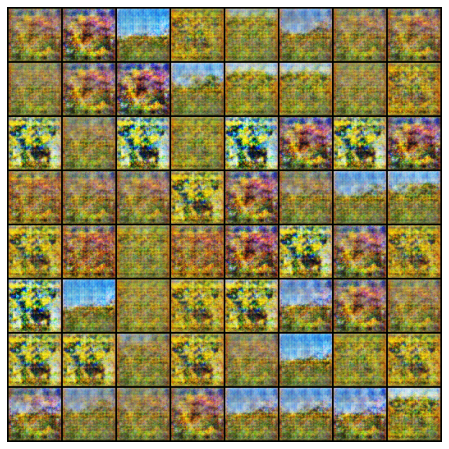

In [32]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

In [13]:
netG.load_state_dict(torch.load('sunflower/netG_epoch_100.pth', map_location=torch.device('cpu')))
netD.load_state_dict(torch.load('sunflower/netD_epoch_100.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
img_list = []
with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

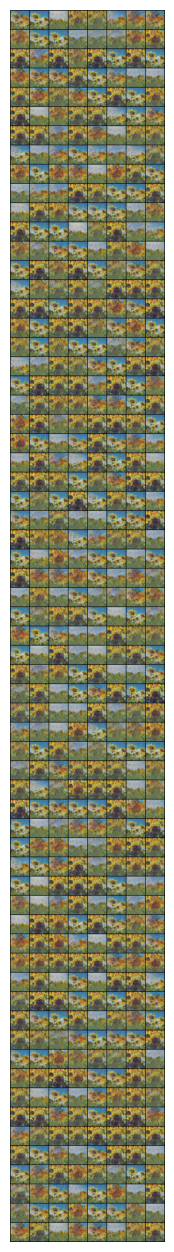

In [22]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


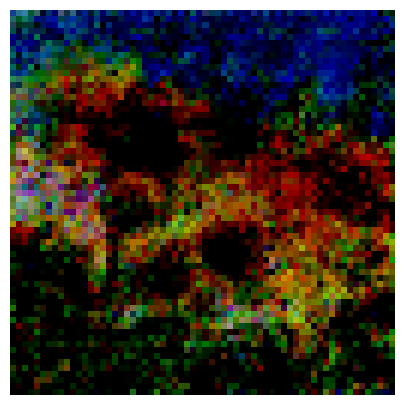

In [16]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()

fake_image = fake[0].permute(1, 2, 0)
fake_image = np.transpose(fake[0],(1,2,0))

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(fake_image,animated=True)
plt.axis('off')
plt.show()


In [ ]:
min_val = np.min(fake_image)
max_val = np.max(fake_image)

# Perform Min-Max Scaling
min_max_scaled_image = (fake_image - min_val) / (max_val - min_val)

In [25]:
plt.imshow(min_max_scaled_image)

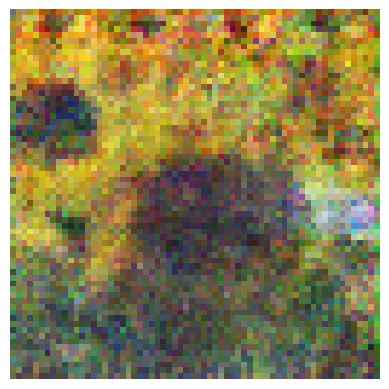

In [26]:
count = 0
for i in range(len(fake)):
    fake_image = np.transpose(fake[i],(1,2,0))
    fake_image_np = fake_image.numpy()

    # Now, you can compute the minimum and maximum values
    min_val = np.min(fake_image_np)
    max_val = np.max(fake_image_np)

    # Perform Min-Max Scaling
    min_max_scaled_image = (fake_image_np - min_val) / (max_val - min_val)
    plt.imshow(min_max_scaled_image)
    plt.axis('off')  # Turn off axis
    plt.savefig(f"sunflower_{count}.jpg", bbox_inches='tight', pad_inches=0)    
    count+=1